In [37]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
from community import community_louvain
import matplotlib.cm as cm
import itertools
import seaborn as sns

In [3]:
concat_voted_df = list()
for date in [2019, 2020, 2021]:
    votes_df = pd.read_csv(f"datasets/votacoesVotos-{date}.csv", delimiter=";")
    votes_df = votes_df[['idVotacao',
                         'deputado_id', 'deputado_nome',
                         'deputado_siglaPartido']]
    votes_df = votes_df.rename(columns={"deputado_siglaPartido": "siglaBancada"})
    concat_voted_df.append(votes_df)

votes_gr_df = pd.concat(concat_voted_df, ignore_index=True)
votes_grouped_df = votes_gr_df.groupby(by=["deputado_id", "deputado_nome", "siglaBancada"]).agg({'idVotacao': lambda x: ','.join(x),}).reset_index()
GO = nx.read_weighted_edgelist("networks/vote19-20-21-orientado-not-normalized.txt", nodetype=int)
GL = nx.read_weighted_edgelist("networks/vote19-20-21-liberado-not-normalized.txt", nodetype=int)

In [4]:
dep_sigla_dict = dict(zip(votes_grouped_df['deputado_id'], votes_grouped_df['siglaBancada']))
nx.set_node_attributes(GO, dep_sigla_dict, name="party")
nx.set_node_attributes(GL, dep_sigla_dict, name="party")

In [5]:
dg_GO = np.array([int(dg) for (nd, dg) in GO.degree()])
dg_GL = np.array([int(dg) for (nd, dg) in GL.degree()])

In [28]:
# Characterization ORIENTADO
print(f"Nodes: {GO.number_of_nodes()}")
print(f"Edges: {GO.number_of_edges()}")
print(f"Global: {nx.transitivity(GO)}")
print(f"Degree max, min, mean, std: {dg_GO.max()}, "
      f"{dg_GO.min()}, {dg_GO.mean()}, {dg_GO.std()}")
print(f"Density: {nx.density(GO)}")
w_edges_o = sorted(GO.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
e_w_o = 0
for e in w_edges_o:
    e_w_o += e[2]['weight']
e_w_o = e_w_o/len(w_edges_o)
print(f"Edge weight max, min, mean: {w_edges_o[0][2]['weight']}, {w_edges_o[-1][2]['weight']}, {e_w_o}")

Nodes: 574
Edges: 158660
Global: 0.9770311042909179
Degree max, min, mean, std: 573, 91, 552.822299651568, 44.88929228623447
Density: 0.9647858632662617
Edge weight max, min, mean: 455.0, 1.0, 126.22962939619312


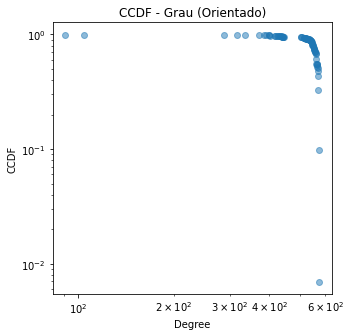

In [20]:
# CCDF
x_g_o, f_k_g_o = np.unique(dg_GO, return_counts=True)
cdf_g_o = f_k_g_o.cumsum()/f_k_g_o.sum()
ccdf_g_o = 1-cdf_g_o

plt.figure(figsize=(5,5))
plt.scatter(x_g_o, ccdf_g_o, alpha=0.5)
plt.title('CCDF - Grau (Orientado)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')

plt.show()

In [27]:
# Characterization LIBERADO
print(f"Nodes: {GL.number_of_nodes()}")
print(f"Edges: {GL.number_of_edges()}")
print(f"Global: {nx.transitivity(GL)}")
print(f"Degree max, min, mean, std: {dg_GL.max()}, "
      f"{dg_GL.min()}, {dg_GL.mean()}, {dg_GL.std()}")
print(f"Density: {nx.density(GL)}")
w_edges_l = sorted(GL.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
e_w_l = 0
for e in w_edges_l:
    e_w_l += e[2]['weight']
e_w_l = e_w_l/len(w_edges_l)
print(f"Edge weight max, min, mean: {w_edges_l[0][2]['weight']}, {w_edges_l[-1][2]['weight']}, {e_w_l}")

Nodes: 559
Edges: 31653
Global: 0.587510858298792
Degree max, min, mean, std: 260, 3, 113.24865831842575, 60.83786535824848
Density: 0.20295458480004616
Edge weight max, min, mean: 15.0, 1.0, 1.5662022557103592


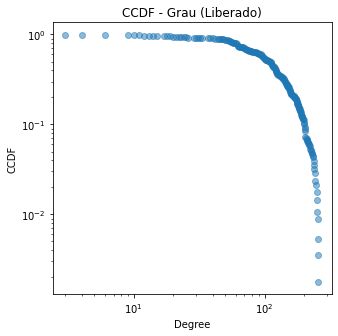

In [24]:
# CCDF
x_g_l, f_k_g_l = np.unique(dg_GL, return_counts=True)
cdf_g_l = f_k_g_l.cumsum()/f_k_g_l.sum()
ccdf_g_l = 1-cdf_g_l

plt.figure(figsize=(5,5))
plt.scatter(x_g_l, ccdf_g_l, alpha=0.5)
#plt.plot(x_g_l, ccdf_g_l, alpha=0.5)
plt.title('CCDF - Grau (Liberado)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')

plt.show()

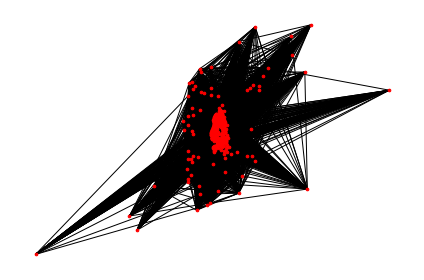

In [8]:
# Draw graph
elarge = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] >= 0.5]
esmall = [(u, v) for (u, v, d) in GO.edges(data=True) if d["weight"] < 0.5]

pos = nx.spring_layout(GO, seed=7)
nx.draw_networkx_nodes(GO, pos, node_size=7, node_color="red")
nx.draw_networkx_edges(GO, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    GO, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="grey", style="dashed"
)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
lv_communities = community_louvain.best_partition(GL)
new_dict = {}
for k, v in lv_communities.items():
    new_dict.setdefault(v, []).append(k)
lv = list(new_dict.values())
print(nx_comm.modularity(GL, lv))

0.41549228126416954


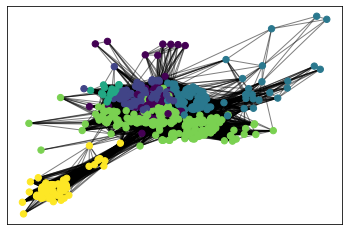

In [10]:
# draw the graph
pos = nx.spring_layout(GL)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(lv_communities.values()) + 1)
nx.draw_networkx_nodes(GL, pos, lv_communities.keys(), node_size=40,
                       cmap=cmap, node_color=list(lv_communities.values()))
nx.draw_networkx_edges(GL, pos, alpha=0.5)
plt.show()

0.3240185083039421


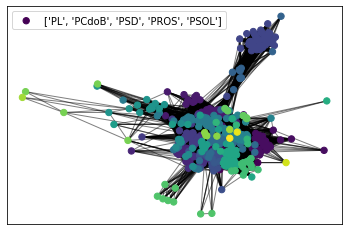

In [36]:
# set attribute as community
dep_new_dict = {}
for k, v in dep_sigla_dict.items():
    dep_new_dict.setdefault(v, []).append(k)
dp = list(dep_new_dict.values())

new_partition = list()
for partition in dp:
    nodes = list()
    for n in partition:
        try:
            GL[n]
            nodes.append(n)
        except:
            pass
    new_partition.append(nodes)

print(nx_comm.modularity(GL, new_partition))

new_partition_p = dict()
i = 0
for partition in new_partition:
    for n in partition:
        new_partition_p[n] = i
    i += 1

# draw the graph
pos_2 = nx.spring_layout(GL)
# color the nodes according to their partition
cmap_2 = cm.get_cmap('viridis', len(list(set(dep_sigla_dict.values()))))
nx.draw_networkx_nodes(GL, pos_2, new_partition_p.keys(), node_size=40,
                       cmap=cmap_2, node_color=list(new_partition_p.values()),
                       )
nx.draw_networkx_edges(GL, pos_2, alpha=0.5)
plt.legend()
plt.show()

In [18]:
# Medium distance inside party
inv_dep_sigla_dict = {}
for k, v in dep_sigla_dict.items():
    inv_dep_sigla_dict[v] = inv_dep_sigla_dict.get(v, []) + [k]

dep_sigla_combination = {}
for k, v in inv_dep_sigla_dict.items():
    dep_sigla_combination[k] = list(itertools.combinations(v,2))

In [45]:
# Similarity between deputies inside same party

medium_distance = {}
for k, v in dep_sigla_combination.items():
    party_distance = 0
    discount = 0
    for comb in v:
        try:
            party_distance += GL[comb[0]][comb[1]]['weight']
        except:
            discount +=1
    try:
        medium_distance[k] = party_distance/(len(v)-discount)
    except:
        medium_distance[k] = party_distance

AtlasView({74200: {'weight': 1.0}, 204397: {'weight': 1.0}, 160642: {'weight': 1.0}, 204494: {'weight': 1.0}})